# CA2 - ML on Agriculture in Ireland and EU

## Overview

Sentiment analysis on data x

2 ML models on data y

...

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

<b>Requirements:</b>

* Instructions to perform the sentiment analysis:

    - NLTK library should be installed


* Instructions to use the Twitter API:

    - There should exist a file called .twitter_env in the machine's home directory with the following keys:

        ```
        API_KEY=***
        API_KEY_SECRET=***
        BEARER_TOKEN=***
        ```

In [22]:
# !pip install punkt
# !pip install python-dotenv
# import nltk
# nltk.download()
from dotenv import dotenv_values
from pathlib import Path
from os import listdir
import os
import re
import json
import string
import logging
import warnings
import requests
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# ignore warnings
warnings.filterwarnings('ignore')

# use a logger to help debugging
logger = logging.getLogger('mylogger')
# set logger level
logger.setLevel(logging.ERROR)

# path to the current directory
CURR_PATH = os.path.abspath(os.getcwd())
# path to the users directory
HOME_DIR = str(Path.home())
# path to dataset dir
DATASET_DIR = os.path.join(CURR_PATH, 'datasets')
# twitter env file
TWITTER_ENV_FILE = '.twitter_env'
# twitter recent search api url
TWITTER_API_SEARCH_URL = 'https://api.twitter.com/2/tweets/search/recent'

def getEnvObj():
    env_path = os.path.join(HOME_DIR, TWITTER_ENV_FILE)

    if not os.path.exists(env_path):
        logger.error(F'Unable to read the environment file. Make sure a { TWITTER_ENV_FILE } file exists in your home directory.')
        return None

    return dotenv_values(env_path)

def createTwitterConfigFile():
    config = getEnvObj()

    if config is None:
        logger.error("Unable to set Twitter's config file.")
        return False

    twitter_keys = f'''keys:
    access_token: {config["API_KEY"]}
    access_token_secret: {config["API_KEY_SECRET"]}
    bearer_token: {config["BEARER_TOKEN"]}
    '''
    keys_path = os.path.join(HOME_DIR, '.twitter-keys.yaml') 
    with open(keys_path, 'w+') as file:
        file.write(twitter_keys)
    logger.info(f"Twitter keys file '{ keys_path }' updated!")

    return True

def bearerAuth(r):
    """
    Method required by bearer token authentication.
    """
    config = getEnvObj()
    
    if config is None:
        raise Exception('Unable to create Bearer authorization object.')

    r.headers['Authorization'] = f"Bearer { config['BEARER_TOKEN'] }"
    r.headers['User-Agent'] = 'v2RecentSearchPython'

    return r

def connectToEndpoint(url, params_dict={}):
    response = requests.get(url, auth=bearerAuth, params=params_dict)

    if response is None:
        raise Exception('Invalid response.')

    logger.info(response.status_code)

    if response.status_code != 200:
        raise Exception(response.status_code, response.text)

    return response.json()

def getRecentTweets(params={}, outfile=''):
    # querying the API
    json_response = connectToEndpoint(TWITTER_API_SEARCH_URL, params)
  
    # save json to file if not empty
    saveJsonToFile(json_response, outfile)
    
    print(f"{ len(json_response['data']) } tweets retrieved!")

    return json_response

def saveJsonToFile(json_data, outfile):
    if len(outfile) == 0:
        logger.warning('Output filename is empty!')
        return

    with open(outfile, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, ensure_ascii=False, indent=4)

def convertJsonToString(json_obj):
    return json.dumps(json_obj, indent=4, sort_keys=True, ensure_ascii=False)

def preProcessText(text, apply_stemmer=False, apply_lemmatizer=False):   
    filtered_words = getTokens(text)

    if apply_stemmer:
        filtered_words = applyStemmer(filtered_words)

    if apply_lemmatizer:
        filtered_words = applyLemmatizer(filtered_words)

    return " ".join(filtered_words)

def getTokens(text):
    return removeStopWords(cleanText(text))

def cleanText(text):
    # convert to lower case
    text = text.lower()
    # remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    # removing special chars
    text = re.sub('[^a-zA-Z]', ' ', text)
    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def removeStopWords(text):
    # convert text into tokes
    text_tokens = word_tokenize(text)
    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [w for w in text_tokens if not w in stop_words]
    return filtered_words
    
def applyStemmer(tokens=[]):
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in tokens]
    return stemmed_words

def applyLemmatizer(tokens=[]):
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in tokens]
    return lemma_words
    

## Sentiment Analysis

In this section, the Twitter API was used to collect tweets from the last few days that will be used for the sentiment analysis.

The purpose of this search was to find tweets about inflation or food price, which relate to the agriculture topic.

However, there is a limitation in the quality of data being collected as the query API feature performs a search by token which can result in tweets about any topic.

### Data Preparation

In [3]:
query_params = {
    'query' : '(inflation OR "food price" OR "agriculture") Europe -is:retweet -has:media lang:en',
    'tweet.fields': 'author_id', 
    'user.fields': 'name',
    "max_results":"100",
}

data = getRecentTweets(query_params, os.path.join(DATASET_DIR, 'twitter_data.json'))

100 tweets retrieved!


In [16]:
# store tweets in a data frame
tweets = [d['text'] for d in data['data']]
tweets_df = pd.DataFrame(tweets, columns=['tweet'])
tweets_df.count()

tweet    100
dtype: int64

In [ ]:
proc_tweets = []
for i in range(0, len(tweets_df)):
    proc = preProcessText(tweets_df.loc[i].tweet, apply_lemmatizer=True)
    proc_tweets.append(proc)
proc_tweets

In [31]:
from nltk.probability import FreqDist

tokens_lst = []
for i in range(0, len(tweets_df)):
    text = tweets_df.loc[i].tweet
    tokens_lst+=getTokens(text)
fdist = FreqDist(tokens_lst)

# Display the frequency distribution
print(fdist)

<FreqDist with 942 samples and 1805 outcomes>


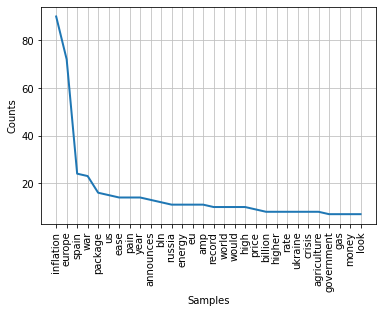

In [33]:
import matplotlib.pyplot as plt

fdist.plot(30, cumulative = False)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate an object cv by calling a method named as CountVectorzer()
cv = CountVectorizer(max_features = 5000, stop_words = ['virginamerica', 'unit'])

# Train the dataset by calling a fit_transform() method
X_fin = cv.fit_transform(cleaned_data).toarray()

# Display the rows and colums
X_fin.shape

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

data = vectorizer.fit_transform(proc_tweets)

# Display the feature names in sorted order
print(vectorizer.get_feature_names())

['abandoned', 'abating', 'abrahamaccords', 'absoluetly', 'abundance', 'acchedin', 'according', 'accurate', 'accuses', 'across', 'adaptability', 'add', 'added', 'adhere', 'adjusted', 'adjustment', 'advanced', 'affecting', 'afghanistan', 'africa', 'agenda', 'aggressive', 'agree', 'agriculture', 'agtwitter', 'aid', 'airdropping', 'airports', 'aliens', 'alive', 'allow', 'ally', 'almost', 'alone', 'along', 'also', 'always', 'america', 'americans', 'amp', 'andalusia', 'announced', 'announces', 'annual', 'another', 'answer', 'anti', 'anything', 'anyway', 'anywhere', 'apc', 'apm', 'appears', 'applying', 'approach', 'area', 'areas', 'argentina', 'arguing', 'around', 'article', 'asia', 'aside', 'ask', 'asked', 'attempt', 'austerity', 'average', 'away', 'awesome', 'back', 'bad', 'badly', 'bank', 'banking', 'bankruptcies', 'banks', 'basically', 'bc', 'became', 'beef', 'begun', 'behind', 'believe', 'belligerent', 'besides', 'best', 'biden', 'bifurcated', 'big', 'billion', 'billions', 'bills', 'bit'

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Declare and initialise a variable t
t = 20

# Declare and initialise an object 'lda' by calling a method LatentDirichletAllocation()
lda = LatentDirichletAllocation(n_components = t, learning_method = 'batch', random_state = 42)

# Train the model
lda.fit(proc_tweets)

# Print all lda components
print(lda.components_)

# Get all feature names
terms = vectorizer.get_feature_names()

In [ ]:
for topic_idx, topic in enumerate(lda.components_):
    print("Topic {}:" .format(topic_idx))
    print(" ".join([terms[i] for i in topic.argsort()[-10:]]))